# Empreedimentos de geração distribuida

Este notebook foi utilizado como caderno de registros para o processo de processamento dos dados fornecidos, a atual versão existe a titulo de rascunho que precisa ser passado a limpo para divulgação.

Descreveremos as operações realizadas para transformação e tratamento da base antes da publicação dos paineis.

Por favor, me contate em caso de dúvidas: caiocsn@hotmail.com

# Importando pacotes

In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine

#  Carregando os dados e aplicando filtros iniciais

In [507]:
df = pd.read_csv(r"C:\Users\caioc\Downloads\empreendimento-geracao-distribuida.csv", encoding = "ISO-8859-1",
                sep = ';')
cols = ['NomAgente', 'DscClasseConsumo', 'DscSubGrupoTarifario', 'SigUF', 'codUFibge', 'codRegiao', 'NomRegiao',
       'CodMunicipioIbge', 'NomMunicipio', 'SigTipoConsumidor', 'CodEmpreendimento', 'SigModalidadeEmpreendimento',
       'SigTipoGeracao', 'DscFonteGeracao', 'DscPorte', 'MdaPotenciaInstaladaKW', 'CodCEP',
       'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento', 'NumCoordESub', 'NumCoordNSub']
df = df[cols]

C:\Users\caioc\AppData\Local\Temp\ipykernel_12492\2407063368.py:1: DtypeWarning: Columns (30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\caioc\Downloads\empreendimento-geracao-distribuida.csv", encoding = "ISO-8859-1",


- Selecionando apenas PJ e excluidno entradas com SigTipoGeracao em ['UHE', 'CGH']
- Corrigindo inconcistências de formatação

In [508]:
sel = (df['SigTipoConsumidor'] == 'PJ') & ~(df['SigTipoGeracao'].isin(['UHE', 'CGH']))
df = df[sel]
df['MdaPotenciaInstaladaKW'] = df['MdaPotenciaInstaladaKW'].str.replace(',', '.').astype(float)
df['NumCoordNEmpreendimento'] = df['NumCoordNEmpreendimento'].str.replace(',','.').astype(float)
df['NumCoordEEmpreendimento'] = df['NumCoordEEmpreendimento'].str.replace(',','.').astype(float)

# Covertendo unidade - calculando GW/mês

In [509]:
data = {
    'Item': ['Radiação solar', 'Biogás - RA', 'Cinética do vento', 'Biogás - RU', 'Gás Natural', 
             'Biogás-AGR', 'Bagaço de Cana de Açúcar', 'Biogás - Floresta', 
             'Gás de Alto Forno - Biomassa', 'Resíduos Florestais', 'Casca de Arroz', 
             'Resíduos Sólidos Urbanos - RU', 'Lenha'],
    'Tipo': ['Solar fotovoltaica', 'Biogás de aterro', 'Eólica', 'Biogás de biodigestão', 'Outro', 
             'Biogás de biodigestão', 'Biomassa', 'Biogás de biodigestão', 
             'Biomassa', 'Biomassa', 'Biomassa', 
             'Outro', 'Biomassa']
}

type_map = pd.DataFrame(data, columns=['Item', 'Tipo'])
type_map = type_map.set_index('Item').to_dict()['Tipo']

df['DscFonteGeracao_tipo'] = df['DscFonteGeracao'].replace(type_map)

In [510]:
data = {
    'Fonte de energia': ['Biogás de aterro', 'Biogás de biodigestão', 'Biogás de biodigestão', 
                         'Biomassa', 'Eólica', 'Hidrelétrica', 'Solar fotovoltaica', 
                         'Solar fotovoltaica', 'Solar fotovoltaica', 'Solar fotovoltaica', 
                         'Outros'],
    'Região': ['Sudeste', 'Centro Oeste', 'Sudeste', 'Sudeste', 'Nordeste', 'Sudeste', 
               'Centro Oeste', 'Nordeste', 'Sudeste', 'Sul', ''],
    'Horas por dia': [5.7, 23.6, 13.2, 6.8, 9.3, 10.6, 5.0, 6.0, 6.7, 6.0, 6.5]
}

prod_map = pd.DataFrame(data, columns=['Fonte de energia', 'Região', 'Horas por dia'])

In [511]:
df['produtividade'] = pd.merge(df, prod_map, how = 'left', left_on = ['DscFonteGeracao_tipo', 'NomRegiao'],
        right_on = ['Fonte de energia', 'Região'])['Horas por dia'].fillna(6.5).values
df['PotenciaGW_mes'] = (df['MdaPotenciaInstaladaKW'] * 30 * df['produtividade'])/1e6

- Classificando as fontes de energia entre 'Solar fotovoltaica', 'Biogás de aterro', 'Eólica',
       'Biogás de biodigestão', 'Outro', 'Biomassa'.
- Atribuindo a produtividade diária a cada um dos tipos tipos de produção
- Calculando a produtividade por mês através da formula: produção_KW * produtividade * 30

In [512]:
df['categoria_de_producao'] = pd.qcut(df['PotenciaGW_mes'], q = [0, .2, .4, .6, .8, .95, 1],
       labels = ['E', 'D', 'C', 'B', 'A', 'S'])

- Classificando a capacidade de produção de cada empreendimento em 6 classes, sendo E a menor e S a maior.

# Adicionando dados de micro e mesoregião

- Cruzando dados do IBGE com os fornecidos na base

In [513]:
cidades_info = pd.read_excel(r"C:\Users\caioc\Downloads\RELATORIO_DTB_BRASIL_MUNICIPIO.xls", skiprows= 6)
region_info = pd.merge(df, cidades_info, how = 'left', left_on = ['CodMunicipioIbge'], 
         right_on = ['Código Município Completo'])[['Nome_Mesorregião', 'Nome_Microrregião']]

df = pd.concat([df.reset_index(), region_info], axis = 1)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


# Inserindo dados populacionais
- Adicionando dados da população referente a cada municipio

In [514]:
population_info = pd.read_excel(r"C:\Users\caioc\Downloads\POP2021_20221212.xls", skiprows = 1,
                               dtype = {'COD. UF': str, 'COD. MUNIC': str}).dropna()
population_info['POPULAÇÃO ESTIMADA'] = population_info['POPULAÇÃO ESTIMADA'].astype(str).str.replace('.', '')
population_info['POPULAÇÃO ESTIMADA'] = population_info['POPULAÇÃO ESTIMADA'].apply(lambda x: x.split('(')[0])
population_info['POPULAÇÃO ESTIMADA'] = population_info['POPULAÇÃO ESTIMADA'].astype(int)
population_info['FULL CODE'] = (population_info['COD. UF'] + population_info['COD. MUNIC']).astype(int)
df['populacao'] = pd.merge(df, population_info, how = 'left', left_on = ['CodMunicipioIbge'],
         right_on = ['FULL CODE'])['POPULAÇÃO ESTIMADA'].values

C:\Users\caioc\AppData\Local\Temp\ipykernel_12492\829061070.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  population_info['POPULAÇÃO ESTIMADA'] = population_info['POPULAÇÃO ESTIMADA'].astype(str).str.replace('.', '')


In [515]:
trash = [region_info]

for t in trash:
    del t

# Explorando

- Explorando algumas características básicas da base de dados para entendimento do próprio analista.

In [516]:
df['DscFonteGeracao'].value_counts(normalize = True)

Radiação solar                   0.998811
Biogás - RA                      0.000482
Cinética do vento                0.000289
Biogás - RU                      0.000123
Gás Natural                      0.000059
Biogás-AGR                       0.000054
Bagaço de Cana de Açúcar         0.000037
Biogás - Floresta                0.000037
Gás de Alto Forno - Biomassa     0.000032
Resíduos Florestais              0.000032
Casca de Arroz                   0.000027
Resíduos Sólidos Urbanos - RU    0.000011
Lenha                            0.000005
Name: DscFonteGeracao, dtype: float64

In [517]:
df['SigTipoGeracao'].value_counts(normalize = True)

UFV    0.998811
UTE    0.000900
EOL    0.000289
Name: SigTipoGeracao, dtype: float64

In [518]:
df.describe(percentiles=[.05, .5, .95])

,index,codUFibge,codRegiao,CodMunicipioIbge,MdaPotenciaInstaladaKW,NumCoordNEmpreendimento,NumCoordEEmpreendimento,produtividade,PotenciaGW_mes,populacao
count,1.867140e+05,186275.000000,186275.000000,1.866940e+05,186714.000000,150174.000000,150174.000000,186714.000000,186714.000000,1.866940e+05
mean,9.682929e+05,35.341919,3538.745291,3.549275e+06,39.276089,-18.270056,-48.611698,6.161340,0.007285,4.363919e+05
std,5.667387e+05,9.377894,937.665453,9.361201e+05,130.506898,9.677359,9.035482,0.544913,0.026876,1.262641e+06
min,2.000000e+00,11.000000,1101.000000,1.100015e+06,0.000000,-72.720000,-76.000000,5.000000,0.000000,8.390000e+02
5%,7.479665e+04,21.000000,2101.000000,2.101202e+06,4.000000,-30.300000,-63.890000,5.000000,0.000740,6.231000e+03
50%,9.966095e+05,35.000000,3505.000000,3.523800e+06,20.000000,-21.020000,-48.980000,6.000000,0.003600,8.600500e+04
95%,1.809821e+06,51.000000,5104.000000,5.107909e+06,75.000000,1.020000,-35.740000,6.700000,0.015075,1.963726e+06
max,1.890784e+06,53.000000,5301.000000,5.300108e+06,5000.000000,8.000000,3.630000,23.600000,2.124000,1.239637e+07


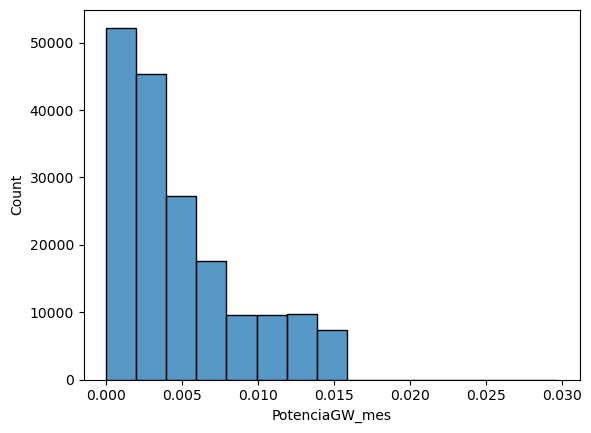

In [519]:
sns.histplot(df[df['DscPorte'] == 'Microgeracao']['PotenciaGW_mes'], bins = 15)
plt.show()

<AxesSubplot:xlabel='PotenciaGW_mes', ylabel='Count'>

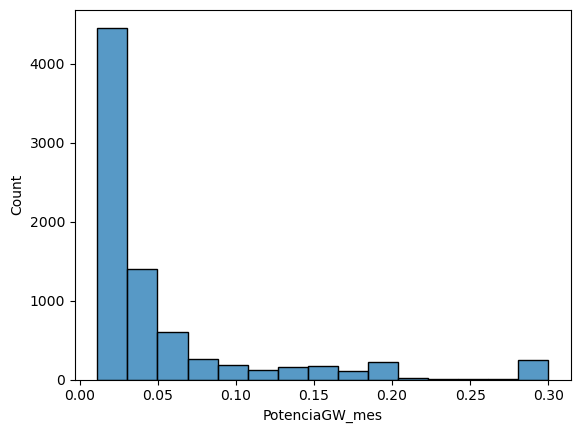

In [520]:
sns.histplot(df[df['DscPorte'] == 'Minigeracao']['PotenciaGW_mes'].clip(upper = .3), bins = 15)

In [521]:
df.groupby('DscPorte').agg(geracaoGW = ('PotenciaGW_mes', 'sum'),
                          usinas = ('MdaPotenciaInstaladaKW', 'count')).sort_values('geracaoGW', ascending = False)

,geracaoGW,usinas
DscPorte,,
Microgeracao,863.368782,178735
Minigeracao,496.777681,7979


In [522]:
df.groupby('NomRegiao').agg(geracaoGW = ('PotenciaGW_mes', 'sum'),
                          usinas = ('MdaPotenciaInstaladaKW', 'count')).sort_values('geracaoGW', ascending = False)

,geracaoGW,usinas
NomRegiao,,
Sudeste,539.537030,68524
Sul,319.285388,48910
Nordeste,256.466026,37445
Centro Oeste,167.678357,22687
Norte,77.179662,9148


In [523]:
df.groupby('SigUF').agg(geracaoGW = ('PotenciaGW_mes', 'sum'),
                          usinas = ('MdaPotenciaInstaladaKW', 'count')).sort_values('geracaoGW', ascending = False)

,geracaoGW,usinas
SigUF,,
SP,239.282536,36598
MG,215.011125,22269
RS,128.023291,22369
PR,100.729892,15614
SC,90.532205,10927
MT,64.063347,8798
RJ,55.541192,6149
CE,53.152415,6149
BA,47.854961,10128


In [524]:
df.groupby('Nome_Mesorregião').agg(geracaoGW = ('PotenciaGW_mes', 'sum'),
                          usinas = ('MdaPotenciaInstaladaKW', 'count')).sort_values('geracaoGW', ascending = False).head(40)

,geracaoGW,usinas
Nome_Mesorregião,,
Grande Florianópolis,55.883214,5425
Norte de Minas,40.450221,2000
Triângulo Mineiro/Alto Paranaíba,39.463725,3489
Metropolitana de Belo Horizonte,39.038354,5124
Metropolitana de Porto Alegre,37.668853,6590
Ribeirão Preto,37.500425,5373
Campinas,31.755355,5237
Metropolitana do Rio de Janeiro,31.600390,3210
Noroeste Rio-grandense,31.147237,6532


In [525]:
df.groupby('Nome_Microrregião').agg(geracaoGW = ('PotenciaGW_mes', 'sum'),
                          usinas = ('MdaPotenciaInstaladaKW', 'count')).sort_values('geracaoGW', ascending = False).head(40)

,geracaoGW,usinas
Nome_Microrregião,,
Florianópolis,55.322381,5334
Fortaleza,23.918145,2754
Brasília,23.381916,1504
Porto Alegre,22.547948,3851
Belo Horizonte,21.966880,3215
Rio de Janeiro,21.474284,2668
Campinas,16.650192,2639
Caxias do Sul,15.929586,2605
São José do Rio Preto,14.828796,2002


## Gerando estatísticas por microrregião

- Agrupando dados por microrregião para gerar visualizações

In [526]:
'''agg_cols = ['Nome_Microrregião','NomAgente', 'DscClasseConsumo', 
            'DscFonteGeracao', 'categoria_de_producao']
energy_production_info = df.groupby(agg_cols).agg(producaoGWh_mes = ('PotenciaGW_mes', 'sum')).reset_index()
microregion_info = pd.merge(population_info, cidades_info, how = 'left',
        left_on = 'FULL CODE', right_on = 'Código Município Completo')[['Nome_UF', 'Nome_Microrregião', 'POPULAÇÃO ESTIMADA']]

microregion_bnfo.columns = ['UF', 'microrregiao', 'populacao']

microregion_info  = microregion_info.groupby(['UF', 'microrregiao']).agg(populacao = ('populacao', 'sum')).reset_index()

microregion_stats = pd.merge(microregion_info, energy_production_info, how = 'left',
        left_on = ['microrregiao'], right_on = ['Nome_Microrregião']).drop('Nome_Microrregião', axis = 1)
microregion_stats = microregion_stats[microregion_stats['producaoGWh_mes'] > 0]
microregion_stats'''

"agg_cols = ['Nome_Microrregião','NomAgente', 'DscClasseConsumo', \n            'DscFonteGeracao', 'categoria_de_producao']\nenergy_production_info = df.groupby(agg_cols).agg(producaoGWh_mes = ('PotenciaGW_mes', 'sum')).reset_index()\nmicroregion_info = pd.merge(population_info, cidades_info, how = 'left',\n        left_on = 'FULL CODE', right_on = 'Código Município Completo')[['Nome_UF', 'Nome_Microrregião', 'POPULAÇÃO ESTIMADA']]\n\nmicroregion_bnfo.columns = ['UF', 'microrregiao', 'populacao']\n\nmicroregion_info  = microregion_info.groupby(['UF', 'microrregiao']).agg(populacao = ('populacao', 'sum')).reset_index()\n\nmicroregion_stats = pd.merge(microregion_info, energy_production_info, how = 'left',\n        left_on = ['microrregiao'], right_on = ['Nome_Microrregião']).drop('Nome_Microrregião', axis = 1)\nmicroregion_stats = microregion_stats[microregion_stats['producaoGWh_mes'] > 0]\nmicroregion_stats"

In [527]:
#microregion_stats.to_csv(r"C:\Users\caioc\Downloads\microrregiao_stats.csv", index = False)

#  Inserindo coordenadas a partir de cep

In [528]:
loc_municipios = pd.read_csv(r"C:\Users\caioc\Downloads\loc_municipios.csv")


In [529]:
ceps = pd.read_csv(r"C:\Users\caioc\Downloads\census_code_cep_coordinates.csv").drop(429993, axis = 0)
ceps['POSTCODE'] = ceps['POSTCODE'].str.replace('-', '')
ceps['PREFIX'] = ceps['POSTCODE'].apply(lambda x: x[:-3])
cep_grouped = ceps.groupby('PREFIX').agg(longitude = ('LON', 'mean'), latitude = ('LAT', 'mean')).reset_index()
df['PREFIX'] = df['CodCEP'].apply(lambda x: x[:-3])

- Carregando base de ceps e atribuindo localização aos empreedimentos de acordo com a cabeça de cep (5 primeiros digitos)

# Reparando campo de localização do empreendimento

- Na base de dados muitas localizações (latitude, longitude) estão erradas, gerando pontos impossíveis ou altamente improváveis dado o municipio em que o empreendimento está registado
- Criamos uma metodologia para detectar localizações improváveis comparando o ponto registrado com o centro do mucípio referente.
- Localizações improváveis foram removidas e substituídas pela localização gerada através do CEP.

In [530]:
def test_coords(x_lat, x_lon,
               municipio_lat, municipio_lon):
    lat_diff = abs(x_lat - municipio_lat)
    lon_diff = abs(x_lon - municipio_lon)
    
    validation = (lat_diff <= 1) & (lon_diff <= 1)
    
    return validation

merged = pd.merge(df, loc_municipios, how = 'left',
        left_on = 'CodMunicipioIbge', right_on = 'codigo_ibge')
df['municipio_lat'] = merged['latitude']
df['municipio_lon'] = merged['longitude']

######
df['lat'] = df['NumCoordNEmpreendimento']
df['lon'] = df['NumCoordEEmpreendimento']
mask = ~df.apply(lambda x: test_coords(x['lat'], x['lon'], x['municipio_lat'], x['municipio_lon']), axis = 1)
df.loc[mask,'lat'] = np.nan
df.loc[mask,'lon'] = np.nan

print(df['lat'].isna().mean())

#####
df['lat'] =df['lat'].fillna(df['NumCoordEEmpreendimento'])
df['lon'] =df['lon'].fillna(df['NumCoordNEmpreendimento'])
mask = ~df.apply(lambda x: test_coords(x['lat'], x['lon'], x['municipio_lat'], x['municipio_lon']), axis = 1)
df.loc[mask,'lat'] = np.nan
df.loc[mask,'lon'] = np.nan
print(df['lat'].isna().mean())


####
merged = pd.merge(df, cep_grouped, how = 'left')
df['lat'] =df['lat'].fillna(merged['latitude'])
df['lon'] =df['lon'].fillna(merged['longitude'])
mask = ~df.apply(lambda x: test_coords(x['lat'], x['lon'], x['municipio_lat'], x['municipio_lon']), axis = 1)
df.loc[mask,'lat'] = np.nan
df.loc[mask,'lon'] = np.nan
print(df['lat'].isna().mean())

### wrong locations dropped to 9%

df['loc'] = df.apply(lambda x: f"{x['lat']}, {x['lon']}", axis = 1)

df['distancia_cidade_km'] = df.apply(lambda x: haversine((x['lat'], x['lon']), (x['municipio_lat'], x['municipio_lon'])), axis = 1)


0.4510106365885793
0.43949034352003596
0.09755026404018981


In [531]:
cols = ['CodEmpreendimento', 'NomAgente','DscClasseConsumo',  'DscSubGrupoTarifario', 'SigUF', 'NomRegiao', 'NomMunicipio', 'SigTipoConsumidor',
  'DscFonteGeracao', 'DscPorte', 'DscFonteGeracao_tipo', 'PotenciaGW_mes', 'categoria_de_producao', 'Nome_Microrregião',
  'populacao', 'loc', 'distancia_cidade_km']
df[cols].to_csv(r"C:\Users\caioc\Downloads\empreendimentos_stats.csv", index = False)